In [1]:
import Pkg; Pkg.add("LinearAlgebra")
import Pkg; Pkg.add("OrdinaryDiffEq")
import Pkg; Pkg.add("NLsolve")
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("LaTeXStrings")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [2]:
using LinearAlgebra
using OrdinaryDiffEq
using NLsolve
using Plots
using LaTeXStrings

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Creating a reference solution using Kvaerno5()

In [3]:
# Defining the ODE
function f!(du, u, parameters, t)
	u1, u2 = u
    du[1] = (-u[2])/(u[1]^2 + u[2]^2)
    du[2] = (u[1])/(u[1]^2 + u[2]^2)
	return nothing
end

f! (generic function with 1 method)

In [4]:
# Starting value and tspan
u0 = [1.0, 0.0]
tspan = tspan = (0., 1.);

In [5]:
# Solving
ode = ODEProblem(f!, u0, tspan)
sol = solve(ode, Kvaerno5());

# Creating the solution with the given method

$ u^{n+1} = u^n + \frac{h}{2} \big( f(u^n) + f(u^{n+1}) \big) + \frac{h^2}{12} \big( g(u^n) + g(u^{n+1}) \big)$

In [6]:
# Defining functions f and g, where g is defined as g=f'f
function f(u::Vector{Float64}, t::Float64)::Vector{Float64}
    return [(-u[2])/(u[1]^2 + u[2]^2),
        (u[1])/(u[1]^2 + u[2]^2)]
end

function g(u::Vector{Float64}, k::Function, t::Float64)
    return [(- (k(u,t)[2] * (u[1]^2 + u[2]^2) - u[2] * (2 * u[1] * k(u,t)[1] - 2 * u[2] * k(u,t)[2]))/((u[1]^2 + u[2]^2)^2)) * k(u,t)[1],
        ((k(u,t)[1] * (u[1]^2 + u[2]^2) - u[1] * (2 * u[1] * k(u,t)[1] - 2 * u[2] * k(u,t)[2]))/((u[1]^2 + u[2]^2)^2)) * k(u,t)[2]]
end

g (generic function with 1 method)

In [7]:
# implement the method using NLsolve
function impl_trap(fhandle::Function, ghandle:: Function, u0::Vector{Float64}, tspan::Tuple{Float64,Float64}, h::Float64)::Tuple{Vector{Float64},Matrix{Float64}}
    t = tspan[1]:h:tspan[2]
    u = zeros(length(u0), length(t))
    u[:,1] = u0
    for i in 1:length(t)-1
        ω = nlsolve(x -> x - u[:,i] - h/2 * (fhandle(u[:,i], t[i]) + fhandle(x, t[i+1])) - h^2/12 * (ghandle(u[:,i], fhandle, t[i]) - ghandle(x, fhandle, t[i+1])), u[:,i]).zero
        u[:,i+1] = u[:,i] + h/2 * fhandle(u[:,i], t[i]) + h/2 * fhandle(ω, t[i+1]) + h^2/12 * ghandle(u[:,i], fhandle, t[i]) - h^2/12 * ghandle(ω, fhandle, t[i+1])
    end
    return t, u
end;

In [8]:
# Choosing the different step sizes I want to check
h = [1/20, 1/18, 1/16, 1/14, 1/10];

In [9]:
# Creating a vector y which contains the errors in the norm of the solution after one step
y = zeros(length(h))
j = 1
for i in h
    y[j] = norm(sol[end] .- impl_trap(f, g, u0, tspan, i)[2][:,end])
    j = j + 1
end 

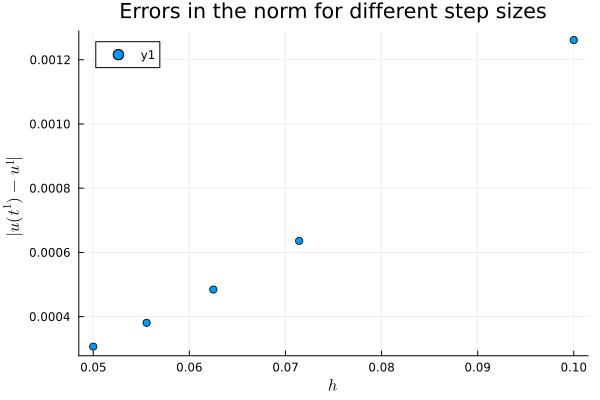

In [10]:
# Plotting the results
scatter(h, y, title="Errors in the norm for different step sizes", xlabel = L"h", yaxis = L"|u(t^1) - u^1|")